# 6103 Tean project

## Drouvas Panagiotis, Dimos Giorgos, Kontoudakis Nikos, Vergas Panagiotis

In [1]:
#library import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

### Part 1.

In [2]:
# libraries specifically for part 1
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

#future selection
from sklearn.feature_selection import mutual_info_classif

#k-means
from sklearn.cluster import KMeans

In [3]:
# based on kddcup.names from kaggle
collumnNames =  [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", 
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", 
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", 
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
    "dst_host_srv_rerror_rate", "label"
]

allData =pd.read_csv('kddcup.data_10_percent', header=None, names = collumnNames)
allData = allData.sample(frac = 0.07)
# last one is the label 
y_labels = allData.iloc[:, -1]
set(y_labels)

{'back.',
 'buffer_overflow.',
 'ftp_write.',
 'guess_passwd.',
 'imap.',
 'ipsweep.',
 'land.',
 'neptune.',
 'nmap.',
 'normal.',
 'pod.',
 'portsweep.',
 'satan.',
 'smurf.',
 'teardrop.',
 'warezclient.',
 'warezmaster.'}

In [4]:
# one hot encoding
data = pd.get_dummies(allData.iloc[:, 0:41], columns=["protocol_type", "service", "flag"])
dataColumns = data.columns
# normalize
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# reduce dimensions
# we will not use pca because we need to chatacterise the clusters
# pca = PCA(n_components=14)
# data = pca.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, y_labels, test_size=0.3, random_state=13)

In [5]:
# information=mutual_info_classif(X_train,y_train)
# print('Information=',information)

## DBSCAN

### loop to find best hyper paramters (I bear no responsibility for burned CPUs)

In [6]:
# evaluationMetricsDBSCAN = []
# # data = X_train.copy()
# print(len(data))
# for i in np.arange(4, 8, 2):
#     for x in [1, 1.5, 2]:  
#         db = DBSCAN(eps=x, min_samples=i).fit(data)
#         core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#         core_samples_mask[db.core_sample_indices_] = True
#         labels = db.labels_
#         n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#         if(len(set(labels))> 1 and n_clusters_ > 1):
#             silhouette_values = silhouette_samples(data, labels)
          
#             # print ('silhouette=', np.mean(silhouette_values))
#             # print('Estimated number of clusters: %d' % n_clusters_)
#             # print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data, labels))

#             evaluationMetricsDBSCAN.append({'min_samples': i, 'eps': x, 'silhouette': round(np.mean(silhouette_values), 3), 'expected number of clusters': n_clusters_})
#         # else:
#             # print("no results for:", len(set(labels)),  n_clusters_)

34581


In [7]:
# metricsDF = pd.DataFrame(evaluationMetricsDBSCAN)
# sortedMetrics= metricsDF.sort_values(by=['silhouette'], ascending= False)
# print(sortedMetrics[:4])
# sortedMetrics= sortedMetrics.sort_values(by=['expected number of clusters'], ascending= True)
# print(sortedMetrics[:4])

   min_samples  eps  silhouette  expected number of clusters
0            4  1.0       0.878                           85
3            6  1.0       0.875                           66
4            6  1.5       0.835                            9
1            4  1.5       0.827                           11
   min_samples  eps  silhouette  expected number of clusters
5            6  2.0       0.780                            3
2            4  2.0       0.780                            3
4            6  1.5       0.835                            9
1            4  1.5       0.827                           11


In [21]:
# once more with the best parameters (we choose something with few clusters)
db = DBSCAN(eps=1.5, min_samples=6).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

### Ploting

In [32]:
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# plt.figure('dbscan')

# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     # core nodes
#     xy = data[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 2], xy[:, 4], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=5)

#     # border nodes
#     xy = data[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=3)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()
# # black is noise.

### dimension reduction (better ploting)

In [30]:
# Compute silhouette score
if len(set(labels)) > 1:
    silhouette_values = silhouette_samples(data, labels)
    print('Silhouette: ', round(np.mean(silhouette_values), 3))
else:
    print("Silhouette score not applicable (only one cluster detected)")

core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
            
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {n_clusters_}")

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

Silhouette:  0.835
Number of clusters: 9


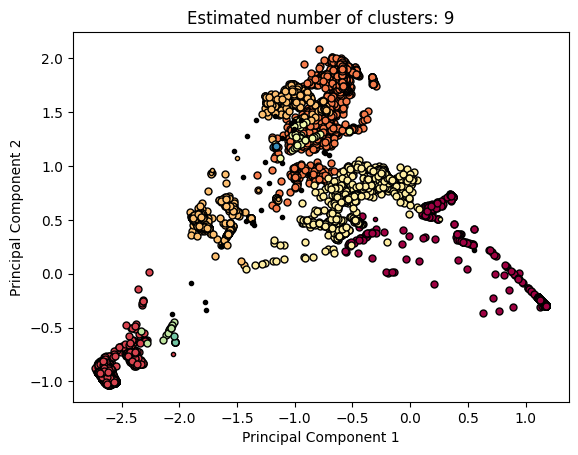

In [31]:
plt.figure('pca-dbscan')
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise

    class_member_mask = (labels == k)

    # Core points
    xy = data_2d[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    # Border points
    xy = data_2d[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [12]:
# Get indices of noise points and print their features
noise_indices = np.where(db.labels_ == -1)[0]   
noise_points = data[noise_indices]
print(noise_points)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 1.81719681e-07 3.47502033e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


# K-Means

In [13]:
allEvaluationMetrics = []
# we need low intertia and high silhouette
for i in  np.arange(2, 10, 1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_train)
    y_kmeans = kmeans.predict(X_train)
    silhouette_values = silhouette_samples(X_train, y_kmeans)
    allEvaluationMetrics.append({'i': i, 'inertia': kmeans.inertia_, 'silhouette': np.mean(silhouette_values)})

allEvaluationMetrics

[{'i': np.int64(2),
  'inertia': 45128.71626151541,
  'silhouette': np.float64(0.6441062568495427)},
 {'i': np.int64(3),
  'inertia': 21159.074006671104,
  'silhouette': np.float64(0.7779840809836984)},
 {'i': np.int64(4),
  'inertia': 11758.149705182585,
  'silhouette': np.float64(0.8357904455619913)},
 {'i': np.int64(5),
  'inertia': 8201.179686976215,
  'silhouette': np.float64(0.8551899837063199)},
 {'i': np.int64(6),
  'inertia': 7946.763636696938,
  'silhouette': np.float64(0.8518800955089328)},
 {'i': np.int64(7),
  'inertia': 6121.271092341072,
  'silhouette': np.float64(0.8612616025282747)},
 {'i': np.int64(8),
  'inertia': 5105.986528213603,
  'silhouette': np.float64(0.8629596256266975)},
 {'i': np.int64(9),
  'inertia': 4448.888370431109,
  'silhouette': np.float64(0.8710458082100949)}]

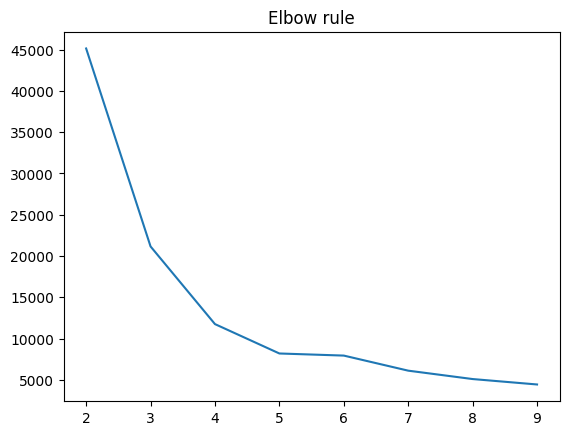

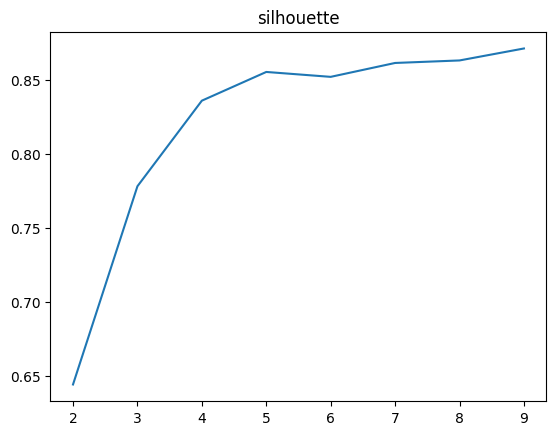

In [14]:
plt.figure('elbow km')
plt.title('Elbow rule')
plt.plot([d['i'] for d in allEvaluationMetrics], [x['inertia'] for x in allEvaluationMetrics])
plt.show()

plt.figure('silhouette km')
plt.title('silhouette')
plt.plot([d['i'] for d in allEvaluationMetrics], [x['silhouette'] for x in allEvaluationMetrics])
plt.show()

In [15]:
# we used the silhouette metric to pick a number of clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train)
y_kmeans = kmeans.predict(X_test)
silhouette_values = silhouette_samples(X_test, y_kmeans)
print(silhouette_values)

[0.83334242 0.93393072 0.99392389 ... 0.74025887 0.91871695 0.99454466]


In [16]:
# Reduce dimensions to two for better ploting
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_test)

<Figure size 640x480 with 0 Axes>

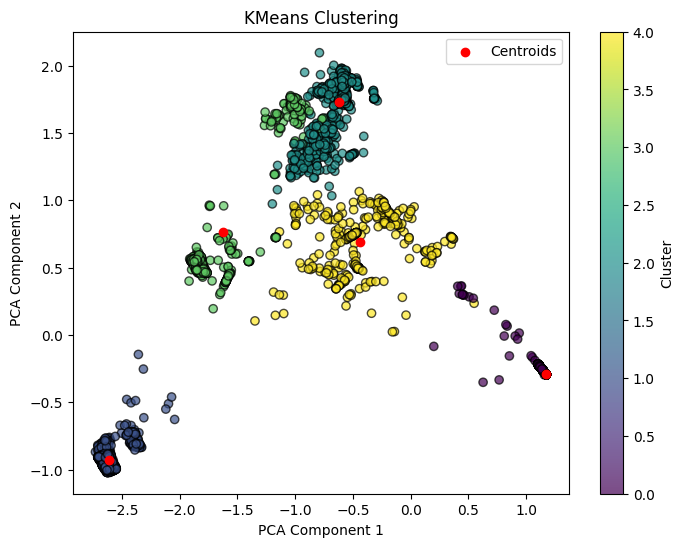

In [17]:
plt.figure('kmeans')
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y_kmeans, cmap='viridis', edgecolors='k', alpha=0.7)
plt.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], 
            pca.transform(kmeans.cluster_centers_)[:, 1], 
            c='red', marker='o', label='Centroids')  # Plot centroids
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"KMeans Clustering")
plt.legend()
plt.show()

In [18]:
## an effort to plot the roc (probabky bot worth it)
# confMatrixTestDB=confusion_matrix(np.where(y_labels == 'normal.', 0, 1), db.labels_, labels=None)
# confMatrixTestKM=confusion_matrix(np.where(y_test == 'normal.', 0, 1), y_kmeans, labels=None)

# print ('Conf matrix DBSCAN')
# print (confMatrixTestDB)
# print ()

# print ('Conf matrix KMeans')
# print (confMatrixTestKM)
# print ()

# # Measures of performance: Precision, Recall, F1


# print(y_labels)
# print(db.labels_)
# print ('DBSCAN: Macro Precision, recall, f1-score')
# print ( precision_recall_fscore_support(np.where(y_labels == 'normal.', 0, 1), db.labels_, average='macro'))
# print ('DBSCAN Micro Precision, recall, f1-score')
# print (precision_recall_fscore_support(np.where(y_labels == 'normal.', 0, 1), db.labels_, average='micro'))
# print ('\n')

# print ('KMeans: Macro Precision, recall, f1-score')
# print ( precision_recall_fscore_support(np.where(y_test == 'normal.', 0, 1), y_kmeans, average='macro'))
# print ('KMeans: Micro Precision, recall, f1-score')
# print (precision_recall_fscore_support(np.where(y_test == 'normal.', 0, 1), y_kmeans, average='micro'))
# print ('\n')

# print ('Support Vector: Macro Precision, recall, f1-score')
# #print ( precision_recall_fscore_support(y_test, y_test_pred_SVM, average='macro'))
# print ('NearNeigh: Micro Precision, recall, f1-score')
# #print (precision_recall_fscore_support(y_test, y_test_pred_SVM, average='micro'))
# print ('\n')




# fpr_kmeans, tpr_kmeans, _ = roc_curve(np.where(y_test == 'normal.', 0, 1), y_kmeans)
# fpr_dbscan, tpr_dbscan, _ = roc_curve(np.where(y_labels == 'normal.', 0, 1), db.labels_)

# # Compute AUC scores
# auc_kmeans = auc(fpr_kmeans, tpr_kmeans)
# auc_dbscan = auc(fpr_dbscan, tpr_dbscan)

# # Plot ROC Curves
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_kmeans, tpr_kmeans, label=f'K-Means (AUC = {auc_kmeans:.2f})', color='blue')
# plt.plot(fpr_dbscan, tpr_dbscan, label=f'DBSCAN (AUC = {auc_dbscan:.2f})', color='red')

# plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for K-Means vs DBSCAN')
# plt.legend()
# plt.show()

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'service_whois', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_SF', 'flag_SH'],
      dtype='object', length=113)


<Figure size 640x480 with 0 Axes>

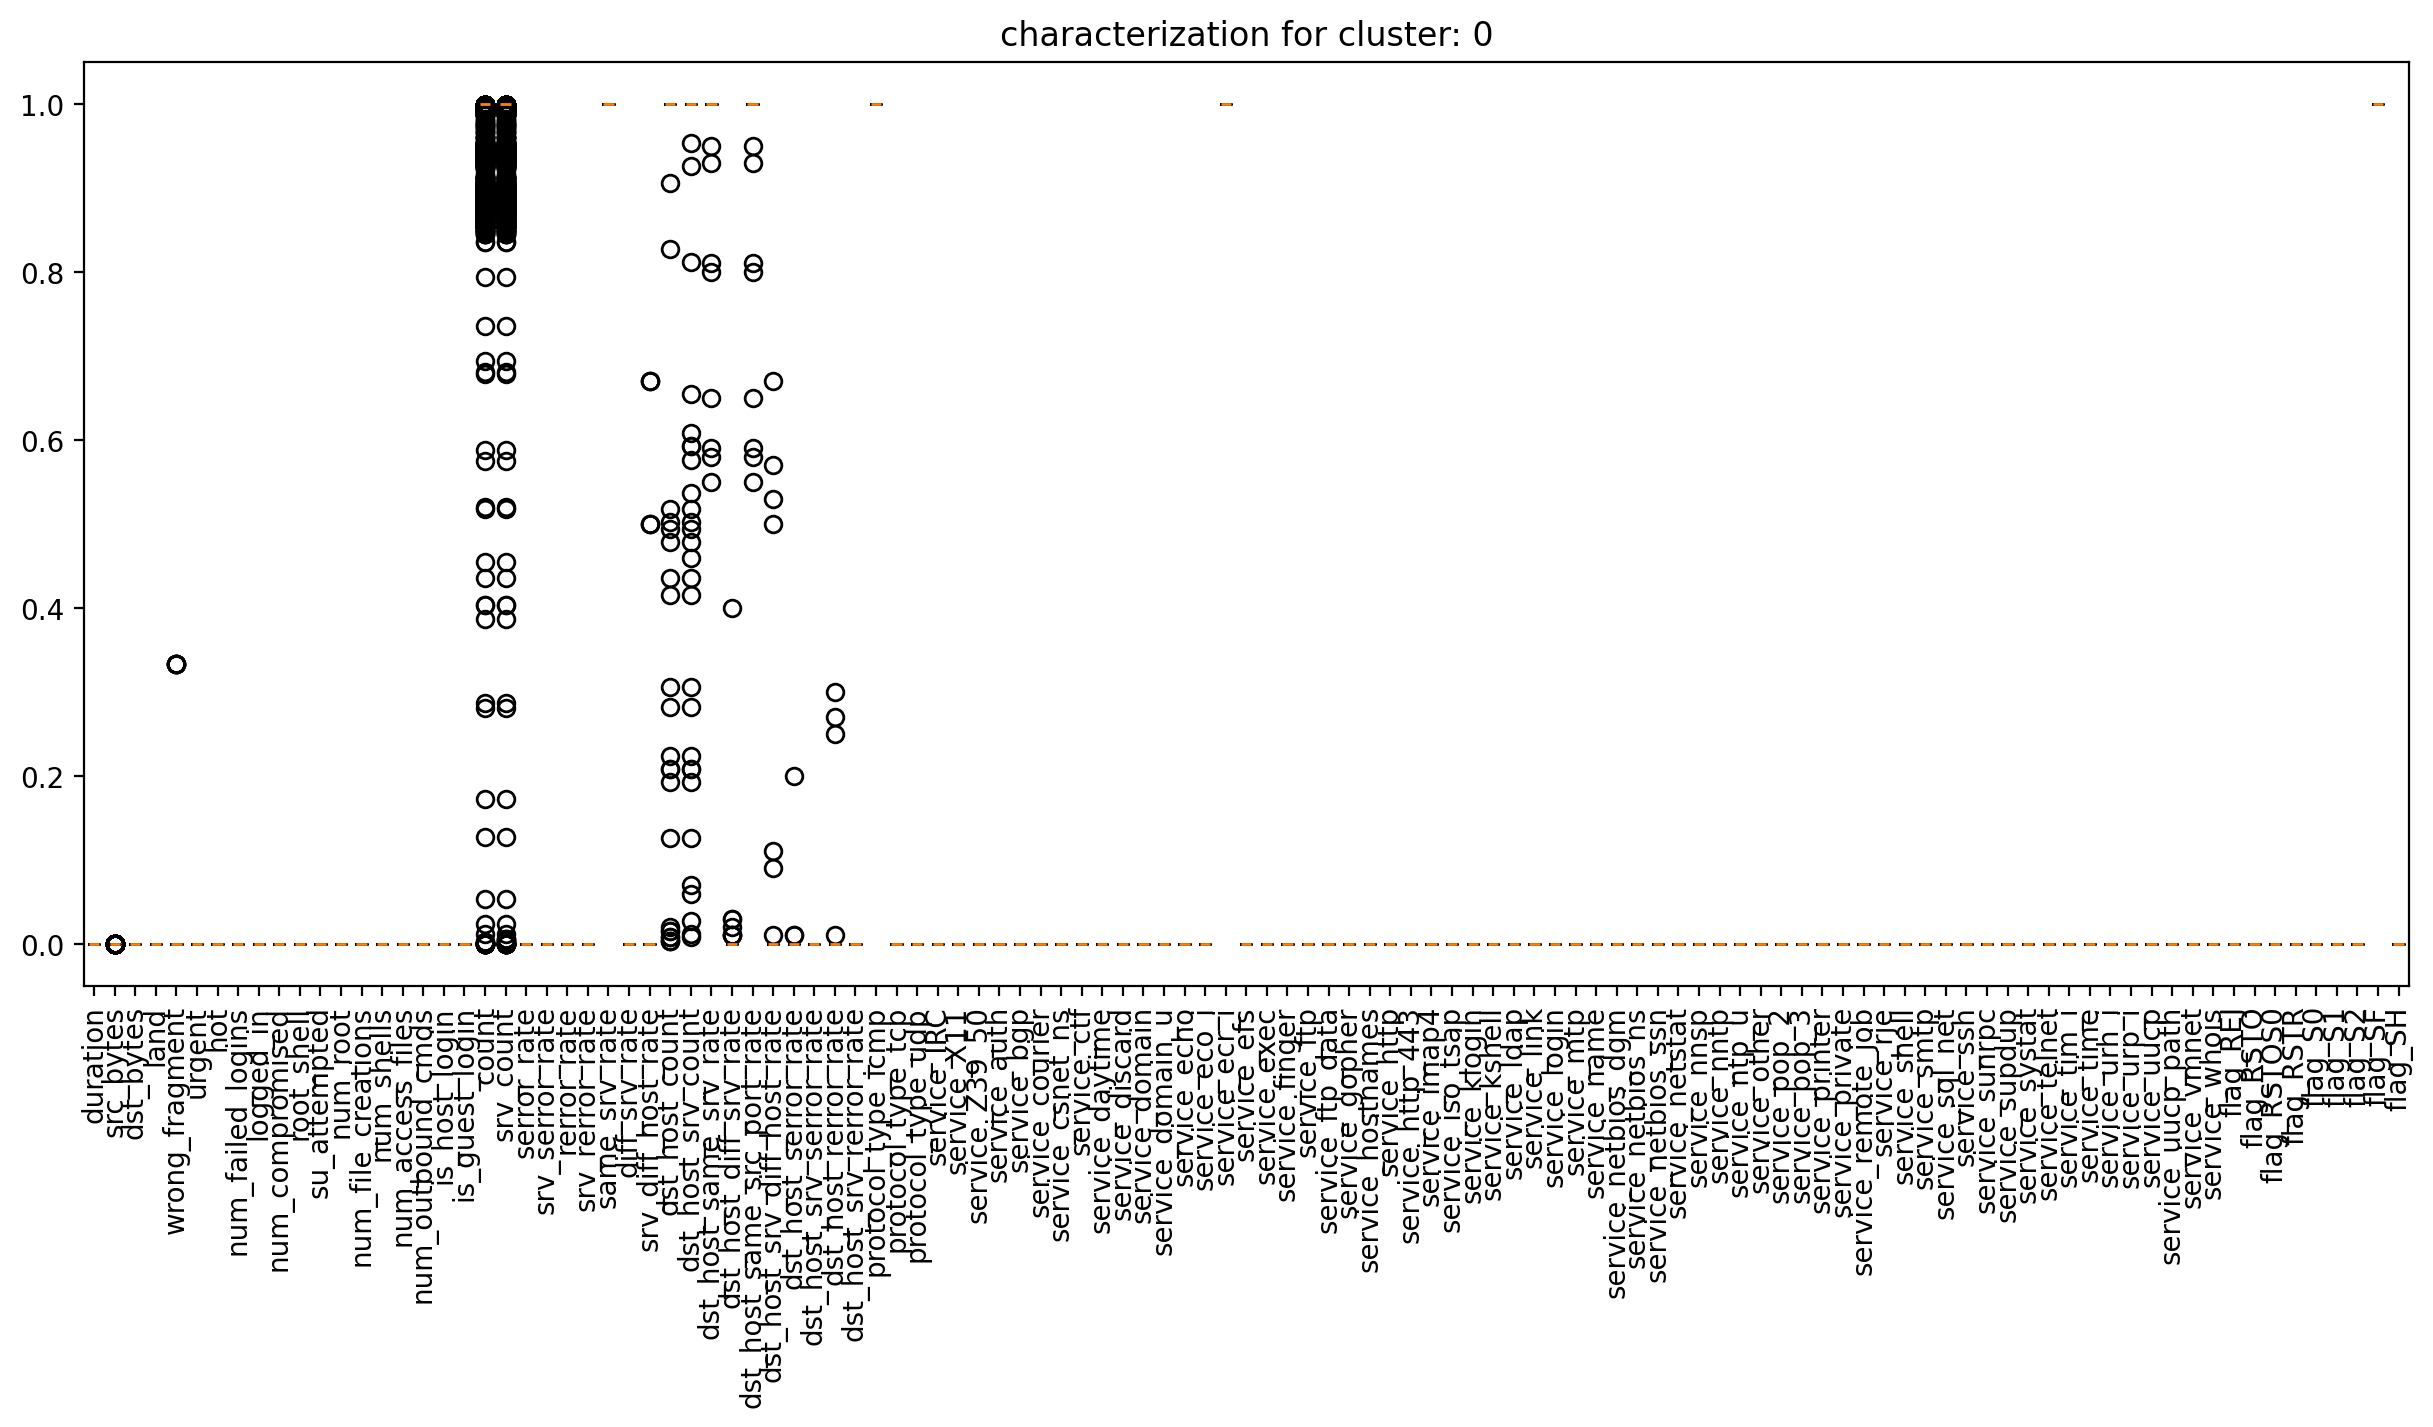

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'service_whois', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_SF', 'flag_SH'],
      dtype='object', length=113)


<Figure size 640x480 with 0 Axes>

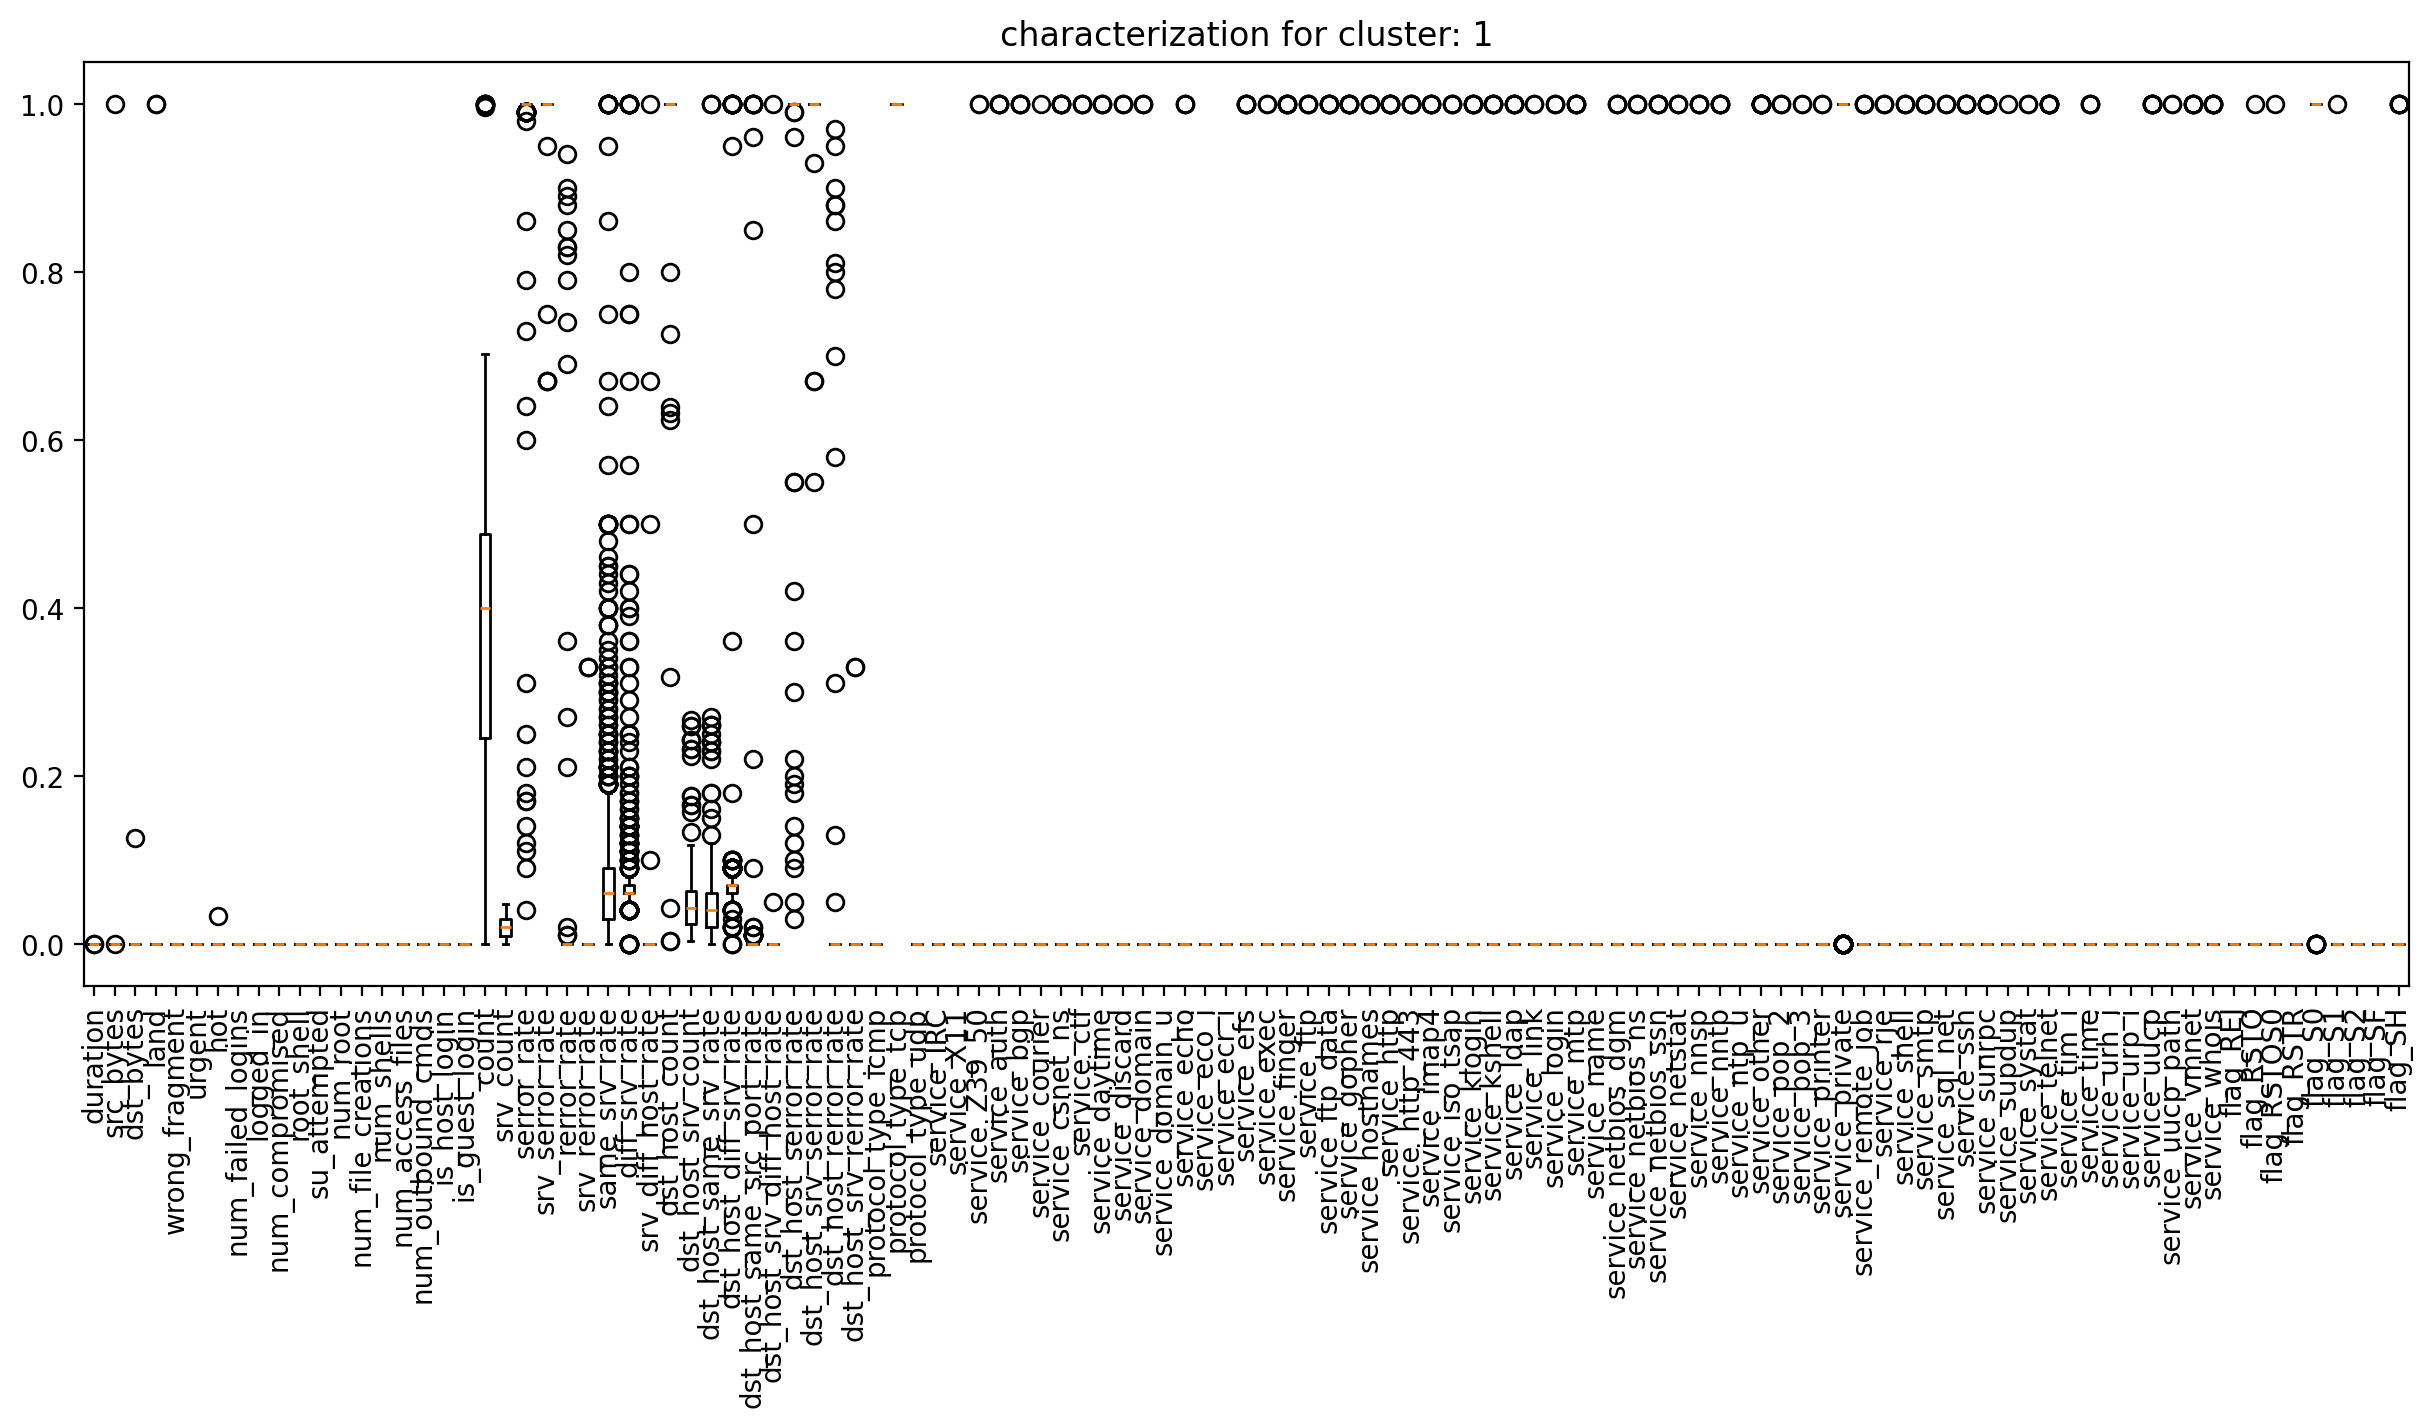

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'service_whois', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_SF', 'flag_SH'],
      dtype='object', length=113)


<Figure size 640x480 with 0 Axes>

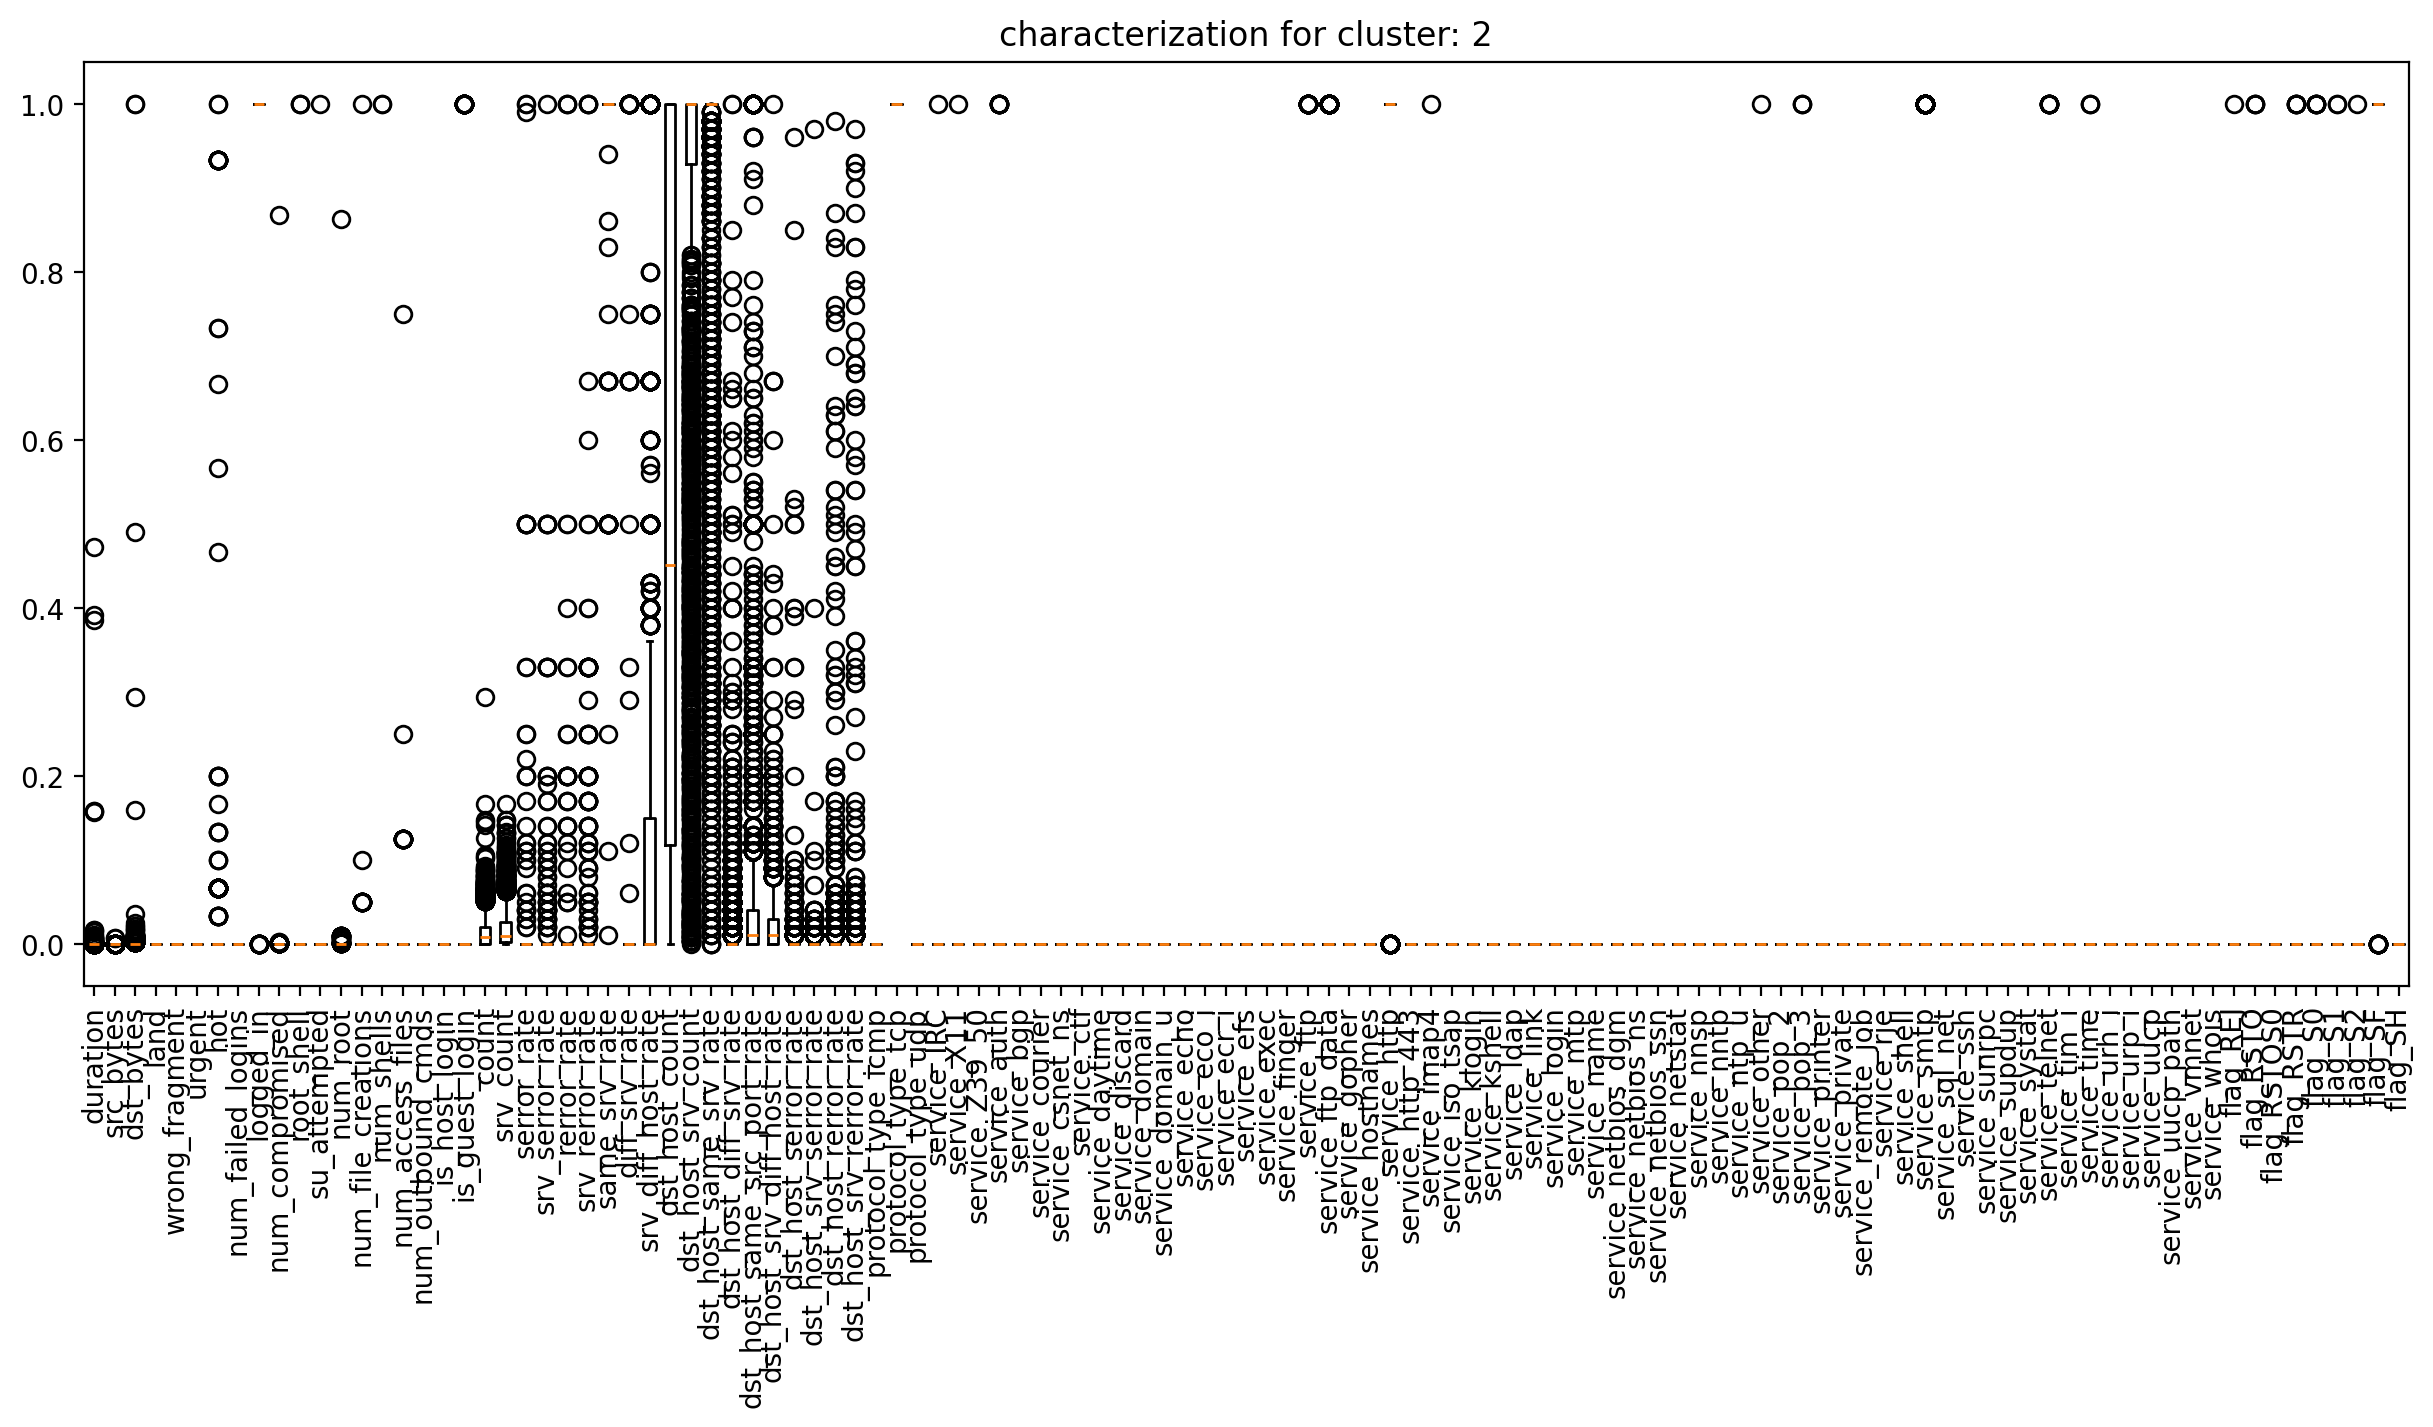

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'service_whois', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_SF', 'flag_SH'],
      dtype='object', length=113)


<Figure size 640x480 with 0 Axes>

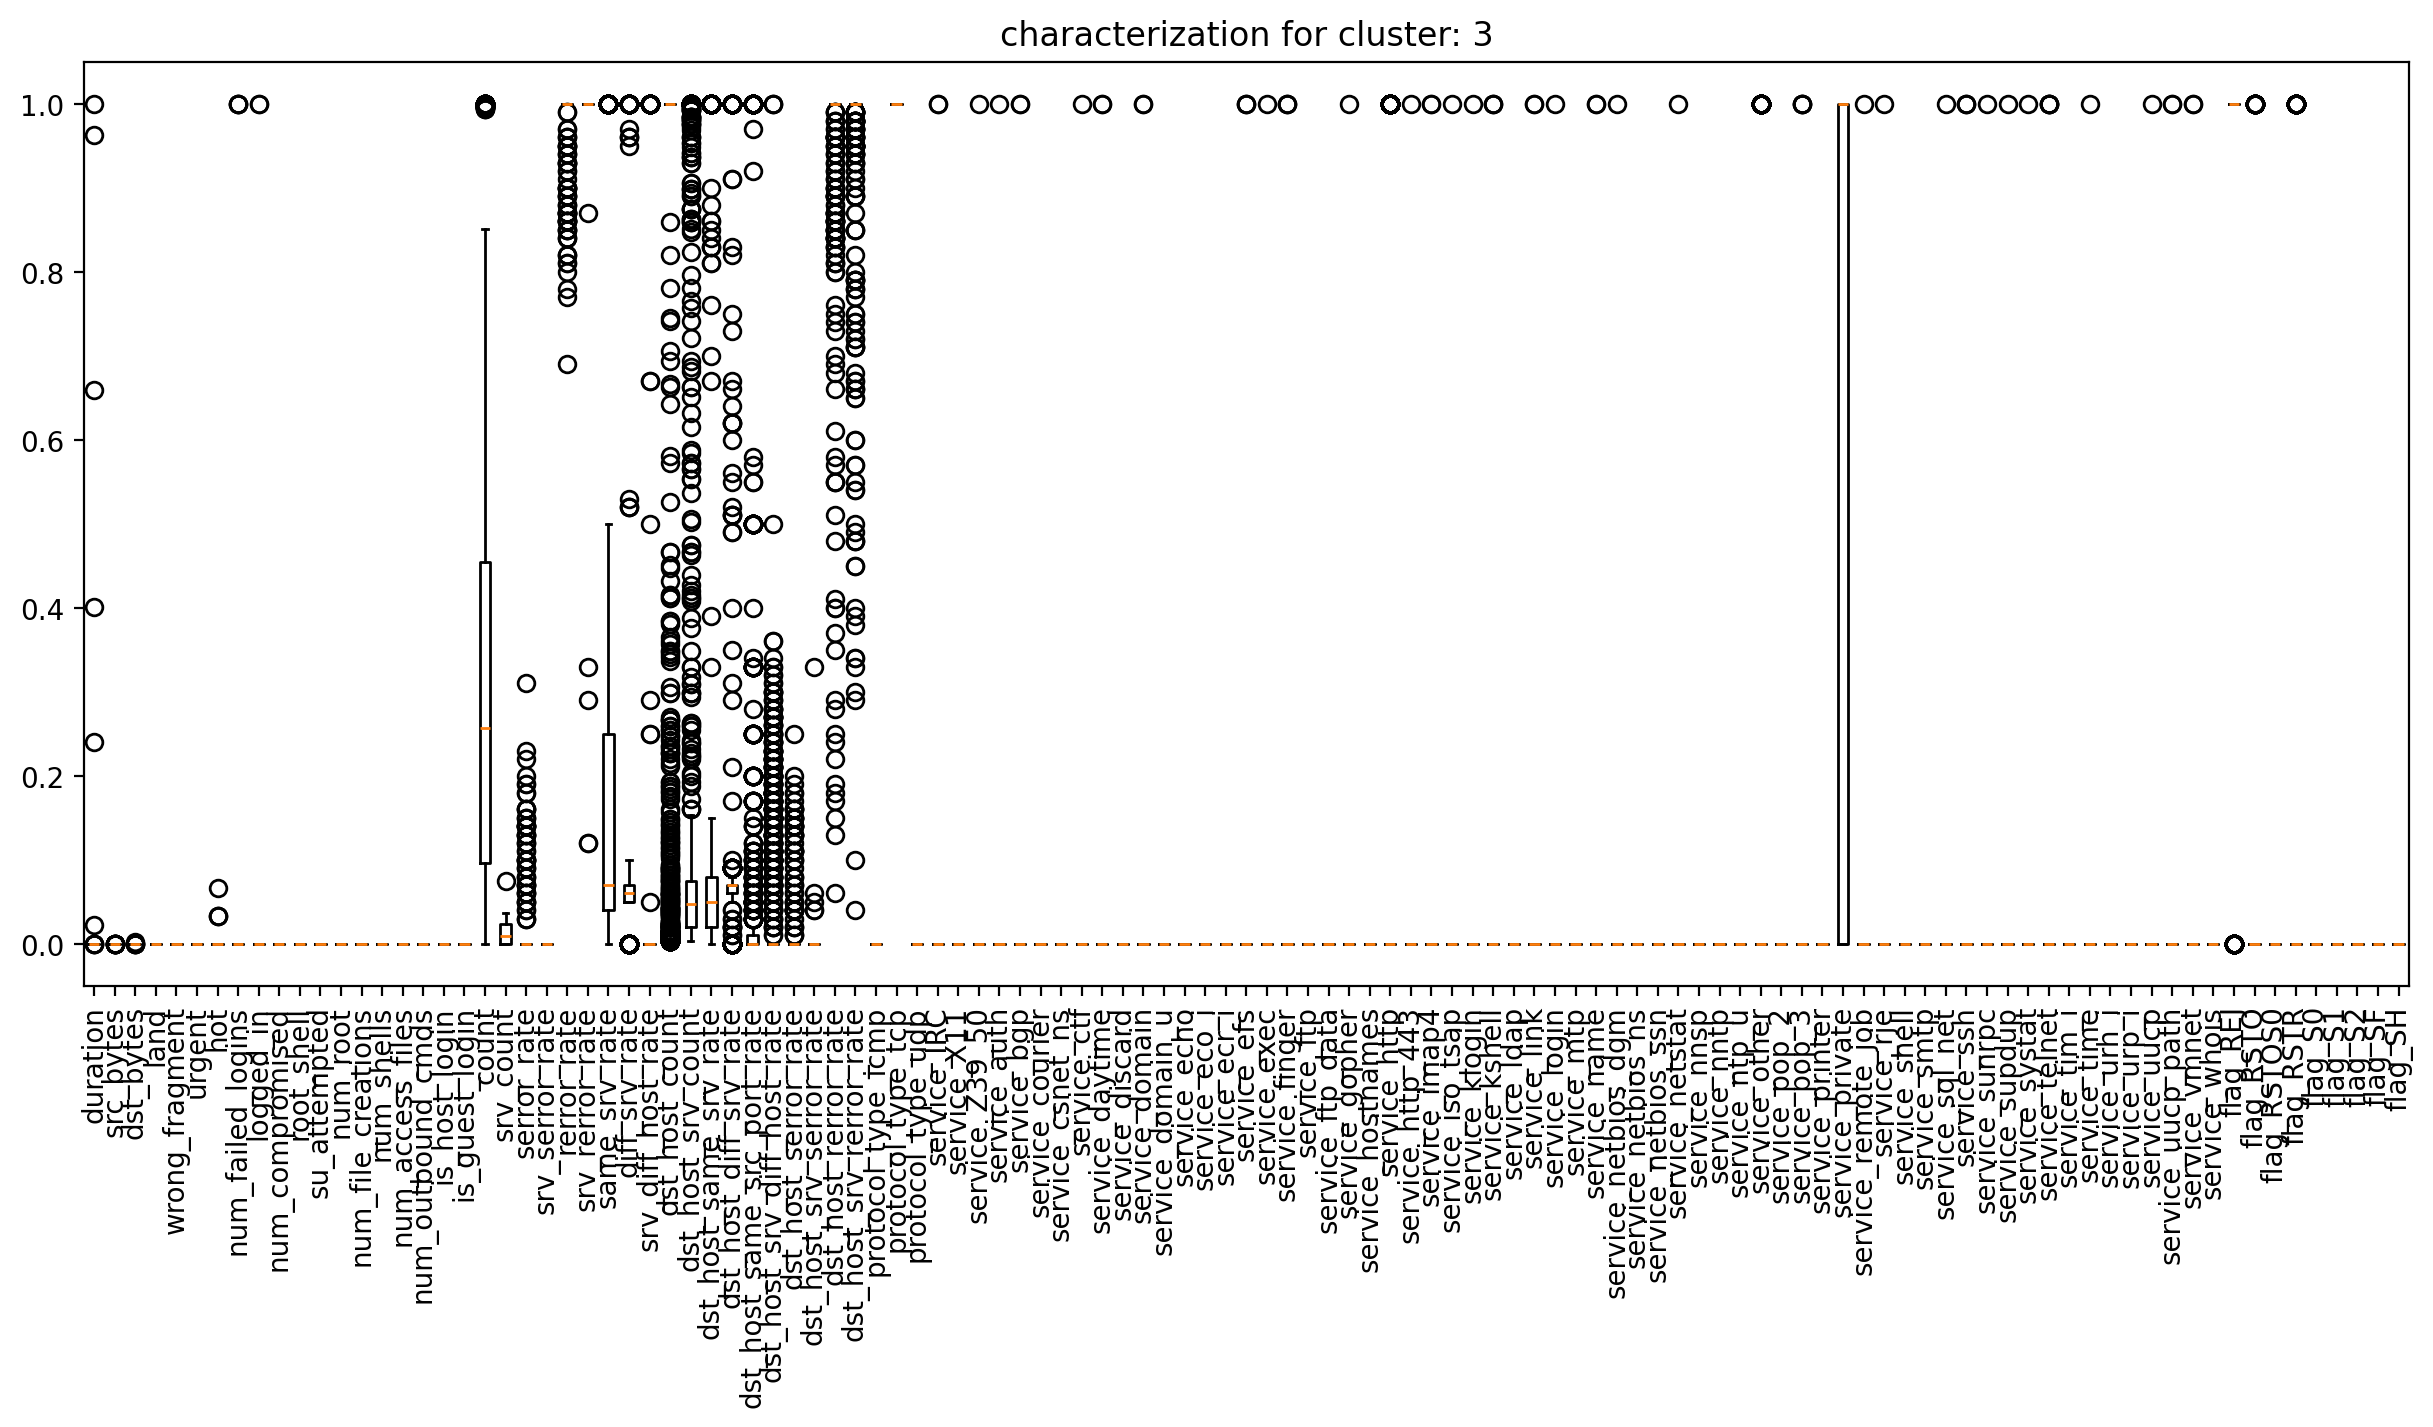

In [19]:
# characterize the clusters
for i in range(0, 4):
    idxCluster=np.where(kmeans.labels_==i)
    plt.figure(f'characterization for cluster: {i}')
    plt.figure(figsize=(15, 6), dpi=200)
    plt.title(f'characterization for cluster: {i}')
    # x-labels are turned 90 degrees
    plt.xticks(rotation=90)
    plt.boxplot(X_train[idxCluster], tick_labels=list(dataColumns))
    plt.show()

In [20]:
# Detect possible abnormal behavior